In [1]:
%matplotlib inline

In [2]:
import os, sys
import re
import glob
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from uncertainties import ufloat

In [3]:
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.width"] = 1.0
plt.rcParams["ytick.major.width"] = 1.0
plt.rcParams["font.size"] = 8
plt.rcParams["axes.linewidth"] = 1.5

In [4]:
formatter = mticker.ScalarFormatter(useMathText=False)
formatter.set_scientific(False)
formatter.set_useOffset(False)

In [5]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

In [6]:
import ipynb_path

root_dir = os.path.dirname(ipynb_path.get())
os.chdir(root_dir)

In [7]:
Ha_to_meV = 27.2114 * 1000

In [8]:
# def read
def read_lrdmc_energy(file):
    with open(file, "r") as f:
        lines = f.readlines()
        for line in lines:
            if re.match(".*Total.*Energy:*", line):
                e_mean = float(line.split()[4])
                e_std = float(line.split()[6])
                return ufloat(e_mean, e_std)
        return ufloat(np.nan, np.nan)

In [9]:
# find the last LRDMC file
def find_max_out_lrdmc_cont(folder_path):
    pattern = re.compile(r"out_lrdmc_cont(\d+)\.o")
    max_x = -1
    max_file = None

    for file_path in glob.glob(os.path.join(folder_path, "out_lrdmc_cont*.o")):
        match = pattern.search(os.path.basename(file_path))
        if match:
            x_value = int(match.group(1))
            if x_value > max_x:
                max_x = x_value
                max_file = file_path

    return max_file

In [10]:
# define functions for fitting.
def fit_E_LRDMC(x, y, y_err, xs, monte_calro_loop=3000, order=2):
    val_pd = pd.DataFrame(index=[], columns=x)
    val_pd_plot = pd.DataFrame(index=[], columns=xs)
    y_zero_list = []
    sigma_list = []
    for v in y:
        sigma_list.append(np.random.randn(monte_calro_loop))

    for m in range(monte_calro_loop):
        y_gen = []
        for i, v in enumerate(y):
            y_gen.append(y[i] + y_err[i] * sigma_list[i][m])

        # polyfit
        w = np.polyfit(x, y_gen, order)
        ys = np.polyval(w, x)
        ys_plot = np.polyval(w, xs)
        c = np.poly1d(w).deriv(1)
        ys_deriv = c(x)
        ys_deriv_plot = c(xs)

        # record
        record = pd.Series(ys, index=val_pd.columns)
        val_pd = val_pd._append(record, ignore_index=True)

        # record for plot
        record = pd.Series(ys_plot, index=val_pd_plot.columns)
        val_pd_plot = val_pd_plot._append(record, ignore_index=True)

        # extrapolated energy
        c = np.poly1d(w)
        y_zero_list.append(c(0.0))

    y_zero_list = np.array(y_zero_list)
    y_mean = np.array(list(val_pd.mean()))
    y_std = np.array(list(val_pd.std()))
    y_mean_plot = np.array(list(val_pd_plot.mean()))
    y_std_plot = np.array(list(val_pd_plot.std()))

    return y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot

In [11]:
# DLTM
alat_list = [0.05, 0.1, 0.15, 0.20, 0.25, 0.3]

# methane
methane_lrdmc_dirs = [os.path.join(root_dir, "01m_ccecp_ccpvtz", "lrdmc_dlatm", f"alat_{alat:.2f}") for alat in alat_list]
methane_lrdmc_files = [find_max_out_lrdmc_cont(methane_lrdmc_dir) for methane_lrdmc_dir in methane_lrdmc_dirs]
methane_lrdmc_energy = [read_lrdmc_energy(methane_lrdmc_file) for methane_lrdmc_file in methane_lrdmc_files]

# water
water_lrdmc_dirs = [os.path.join(root_dir, "02w_ccecp_ccpvtz", "lrdmc_dlatm", f"alat_{alat:.2f}") for alat in alat_list]
water_lrdmc_files = [find_max_out_lrdmc_cont(water_lrdmc_dir) for water_lrdmc_dir in water_lrdmc_dirs]
water_lrdmc_energy = [read_lrdmc_energy(water_lrdmc_file) for water_lrdmc_file in water_lrdmc_files]

# water-methane
water_methane_lrdmc_dirs = [
    os.path.join(root_dir, "03m_w_ccecp_ccpvtz", "lrdmc_dlatm", f"alat_{alat:.2f}") for alat in alat_list
]
water_methane_lrdmc_files = [
    find_max_out_lrdmc_cont(water_methane_lrdmc_dir) for water_methane_lrdmc_dir in water_methane_lrdmc_dirs
]
water_methane_lrdmc_energy = [
    read_lrdmc_energy(water_methane_lrdmc_file) for water_methane_lrdmc_file in water_methane_lrdmc_files
]

# binding energy
binding_energy = [
    (mw - m - w) * Ha_to_meV for m, w, mw in zip(methane_lrdmc_energy, water_lrdmc_energy, water_methane_lrdmc_energy)
]

# methane(tau)
methane_lrdmc_tau_dirs = [
    os.path.join(root_dir, "01m_ccecp_ccpvtz", "lrdmc_dlatm_tau", f"alat_{alat:.2f}") for alat in alat_list
]
methane_lrdmc_tau_files = [find_max_out_lrdmc_cont(methane_lrdmc_tau_dir) for methane_lrdmc_tau_dir in methane_lrdmc_tau_dirs]
methane_lrdmc_tau_energy = [read_lrdmc_energy(methane_lrdmc_tau_file) for methane_lrdmc_tau_file in methane_lrdmc_tau_files]

# water(tau)
water_lrdmc_tau_dirs = [os.path.join(root_dir, "02w_ccecp_ccpvtz", "lrdmc_dlatm_tau", f"alat_{alat:.2f}") for alat in alat_list]
water_lrdmc_tau_files = [find_max_out_lrdmc_cont(water_lrdmc_tau_dir) for water_lrdmc_tau_dir in water_lrdmc_tau_dirs]
water_lrdmc_tau_energy = [read_lrdmc_energy(water_lrdmc_tau_file) for water_lrdmc_tau_file in water_lrdmc_tau_files]

In [12]:
methane_lrdmc_energy

[-8.0787+/-2.7e-05,
 -8.07888+/-1.8e-05,
 -8.07907+/-2.1e-05,
 -8.07923+/-2.1e-05,
 -8.07965+/-2.5e-05,
 -8.08004+/-2.2e-05]

In [13]:
water_lrdmc_energy

[-17.23483+/-2.6e-05,
 -17.23516+/-2.4e-05,
 -17.23559+/-2.5e-05,
 -17.23616+/-2.2e-05,
 -17.23688+/-2.2e-05,
 -17.23735+/-2.3e-05]

In [14]:
water_methane_lrdmc_energy

[-25.31462+/-8.2e-05,
 -25.31502+/-3.9e-05,
 -25.31565+/-3.5e-05,
 -25.31655+/-3.5e-05,
 -25.31757+/-3.2e-05,
 -25.3186+/-3e-05]

In [15]:
methane_lrdmc_tau_energy

[-8.07877+/-5.9e-05,
 -8.07883+/-4.5e-05,
 -8.07902+/-4.3e-05,
 -8.07932+/-3.7e-05,
 -8.07964+/-4.2e-05,
 -8.08007+/-4.6e-05]

In [16]:
water_lrdmc_tau_energy

[-17.23493+/-5.1e-05,
 -17.23514+/-4.2e-05,
 -17.23562+/-4.6e-05,
 -17.23622+/-4.7e-05,
 -17.2368+/-6e-05,
 -17.23723+/-4.8e-05]

In [17]:
# DLTM
methane_dmc_energy_ref = {
    "turborvb": {
        0.05: ufloat(-8.07863725350115, 2.007783144929091e-005),
        0.1: ufloat(-8.07872518700326, 1.974380803423459e-005),
        0.15: ufloat(-8.07890468792634, 2.064008242842857e-005),
        0.2: ufloat(-8.07906886517978, 2.031740406073541e-005),
        0.25: ufloat(-8.07926446997123, 1.993042425537716e-005),
        0.3: ufloat(-8.07956101247059, 2.071876657482551e-005),
    },
    "turborvb-tau": {
        0.05: ufloat(-8.078634348, 1.53e-05),
        0.10: ufloat(-8.078754283, 1.54e-05),
        0.15: ufloat(-8.078894674, 1.54e-05),
        0.20: ufloat(-8.079092898, 1.56e-05),
        0.25: ufloat(-8.079288205, 1.53e-05),
        0.30: ufloat(-8.079599295, 1.51e-05),
    },
    "qmcpack": {
        0.08: ufloat(-8.080768877092906, 2.702815549577107e-05),
        0.04: ufloat(-8.07972495832564, 1.8914154623871482e-05),
        0.02: ufloat(-8.079213989222325, 2.0974144206585715e-05),
        0.01: ufloat(-8.078899791509691, 2.2906267866775823e-05),
        0.005: ufloat(-8.078725807033866, 2.0020278227736306e-05),
        0.0025: ufloat(-8.078635816623551, 2.14341417734811e-05),
    },
    "casino": {
        0.64: ufloat(-8.093779514343998, 1.1165414845150535e-05),
        0.32: ufloat(-8.083517956014536, 1.2240868573175693e-05),
        0.16: ufloat(-8.079344709549877, 1.4843301799731997e-05),
        0.08: ufloat(-8.078025044940263, 1.6291093613138255e-05),
        0.04: ufloat(-8.077901161115454, 1.506202234024889e-05),
        0.02: ufloat(-8.078105857593883, 1.5988963155089308e-05),
        0.01: ufloat(-8.078250643817793, 1.6430960413721432e-05),
        0.005: ufloat(-8.078390651284371, 1.4967553583207512e-05),
        0.0025: ufloat(-8.07847659061949, 1.6353562423645458e-05),
    },
    "cmqmc": {
        0.08: ufloat(-8.08059671, 0.00001962),
        0.04: ufloat(-8.07931566, 0.0000196),
        0.02: ufloat(-8.07881482, 0.00001969),
        0.01: ufloat(-8.07862593, 0.00001998),
        0.005: ufloat(-8.07854932, 0.00001994),
        0.0025: ufloat(-8.07854445, 0.00002),
    },
}

water_dmc_energy_ref = {
    "turborvb": {
        0.05: ufloat(-17.2348523355299, 1.948771103565163e-005),
        0.1: ufloat(-17.2350934056939, 2.132347315677264e-005),
        0.15: ufloat(-17.2353459101424, 1.971679846194777e-005),
        0.2: ufloat(-17.2357081469664, 1.984181239277189e-005),
        0.25: ufloat(-17.2360828342762, 2.021221539942189e-005),
        0.3: ufloat(-17.2364813799475, 1.986614852331951e-005),
    },
    "turborvb-tau": {
        0.05: ufloat(-17.23486697, 1.40e-05),
        0.10: ufloat(-17.23507474, 1.35e-05),
        0.15: ufloat(-17.23539581, 1.37e-05),
        0.20: ufloat(-17.23572876, 1.39e-05),
        0.25: ufloat(-17.23610915, 1.39e-05),
        0.30: ufloat(-17.23648320, 1.32e-05),
    },
    "qmcpack": {
        0.08: ufloat(-17.2434189841611, 2.6396278427460472e-05),
        0.04: ufloat(-17.239453109288, 2.5813340177210553e-05),
        0.02: ufloat(-17.23742344452136, 2.3988035574147145e-05),
        0.01: ufloat(-17.236218947004076, 2.5050384331373678e-05),
        0.005: ufloat(-17.235511971448112, 2.452840158140857e-05),
        0.0025: ufloat(-17.23520218477908, 2.1321806493765432e-05),
    },
    "casino": {
        0.64: ufloat(-17.283771390853477, 2.0027378005577987e-05),
        0.32: ufloat(-17.25257899170143, 2.1830682505879327e-05),
        0.16: ufloat(-17.239870516889944, 2.1016657777142013e-05),
        0.08: ufloat(-17.234759632969777, 2.635196895746475e-05),
        0.04: ufloat(-17.23340066103765, 2.292114805130096e-05),
        0.02: ufloat(-17.23350562958967, 2.101347339269575e-05),
        0.01: ufloat(-17.23394956292525, 2.2332781981705757e-05),
        0.005: ufloat(-17.23427019536041, 2.129980942494666e-05),
        0.0025: ufloat(-17.23447016009584, 1.9493613840996026e-05),
    },
    "cmqmc": {
        0.08: ufloat(-17.24312519, 0.00001976),
        0.04: ufloat(-17.23885874, 0.00001969),
        0.02: ufloat(-17.23673078, 0.00001988),
        0.01: ufloat(-17.23566294, 0.00001993),
        0.005: ufloat(-17.23511252, 0.00001995),
        0.0025: ufloat(-17.23487332, 0.00002),
    },
}

water_methane_dmc_energy_ref = {
    "turborvb": {
        0.05: ufloat(-25.3145430199628, 2.557643572216775e-005),
        0.1: ufloat(-25.3148984242431, 2.602587518500364e-005),
        0.15: ufloat(-25.3153358645290, 2.693813440416903e-005),
        0.2: ufloat(-25.3159190296866, 2.663894219105420e-005),
        0.25: ufloat(-25.3165209871803, 2.699715386171810e-005),
        0.3: ufloat(-25.3171920385458, 2.596245868271072e-005),
    },
    "turborvb-tau": {
        0.05: ufloat(-25.31454658, 2.07e-05),
        0.10: ufloat(-25.31488331, 1.09e-05),
        0.15: ufloat(-25.31534936, 1.07e-05),
        0.20: ufloat(-25.31591077, 1.07e-05),
        0.25: ufloat(-25.31652186, 1.10e-05),
        0.30: ufloat(-25.31718788, 1.06e-05),
    },
    "qmcpack": {
        0.08: ufloat(-25.32672198105947, 4.043805860882674e-05),
        0.04: ufloat(-25.321039280851423, 3.6657521682864494e-05),
        0.02: ufloat(-25.318028658346265, 3.6502026942973945e-05),
        0.01: ufloat(-25.316438746752326, 3.4028094465875924e-05),
        0.005: ufloat(-25.31541558440216, 3.460211104941045e-05),
        0.0025: ufloat(-25.314929434613028, 3.558302712943598e-05),
    },
    "casino": {
        0.64: ufloat(-25.383267207294494, 2.8798192334045298e-05),
        0.32: ufloat(-25.338124112513977, 2.9747436786168356e-05),
        0.16: ufloat(-25.3204123013807, 2.941925509261321e-05),
        0.08: ufloat(-25.31370170516422, 2.7781448346466094e-05),
        0.04: ufloat(-25.31216322000225, 3.364126350402864e-05),
        0.02: ufloat(-25.312493382691937, 2.89819456892005e-05),
        0.01: ufloat(-25.313059204783798, 3.284249786762957e-05),
        0.005: ufloat(-25.313576014015133, 3.1807081996101304e-05),
        0.0025: ufloat(-25.31395044794631, 2.6787472964598265e-05),
    },
    "cmqmc": {
        0.08: ufloat(-25.32463214, 0.00001993),
        0.04: ufloat(-25.31917836, 0.00001995),
        0.02: ufloat(-25.31659066, 0.00001996),
        0.01: ufloat(-25.31533248, 0.00001998),
        0.005: ufloat(-25.31468018, 0.00001999),
        0.0025: ufloat(-25.31443446, 0.00001999),
    },
}

binding_energy_ref = {}
package_list = ["turborvb", "turborvb-tau", "casino", "qmcpack", "cmqmc"]
for package in package_list:
    binding_energy_ref[package] = {
        tau: (
            water_methane_dmc_energy_ref[package][tau]
            - water_dmc_energy_ref[package][tau]
            - methane_dmc_energy_ref[package][tau]
        )
        * Ha_to_meV
        for tau in water_methane_dmc_energy_ref[package].keys()
    }

jQMC-methane: -8.07870(1)
TurboRVB-methane: -8.07862(2)
jQMC-methane(tau): -8.07870(3)
jQMC-water: -17.23472(2)
TurboRVB-water: -17.23482(2)
jQMC-water(tau): -17.23478(4)
jQMC-methane-water: -25.31459(4)
TurboRVB-methane-water: -25.31447(2)
jQMC: Binding energy of Methane-Water dimer = -27.6(1.2) meV
TurboRVB: Binding energy of Methane-Water dimer = -29.0(7) meV
QMCPACK: Binding energy of Methane-Water dimer = -29.0(1.0) meV
CASINO: Binding energy of Methane-Water dimer = -25.9(7) meV


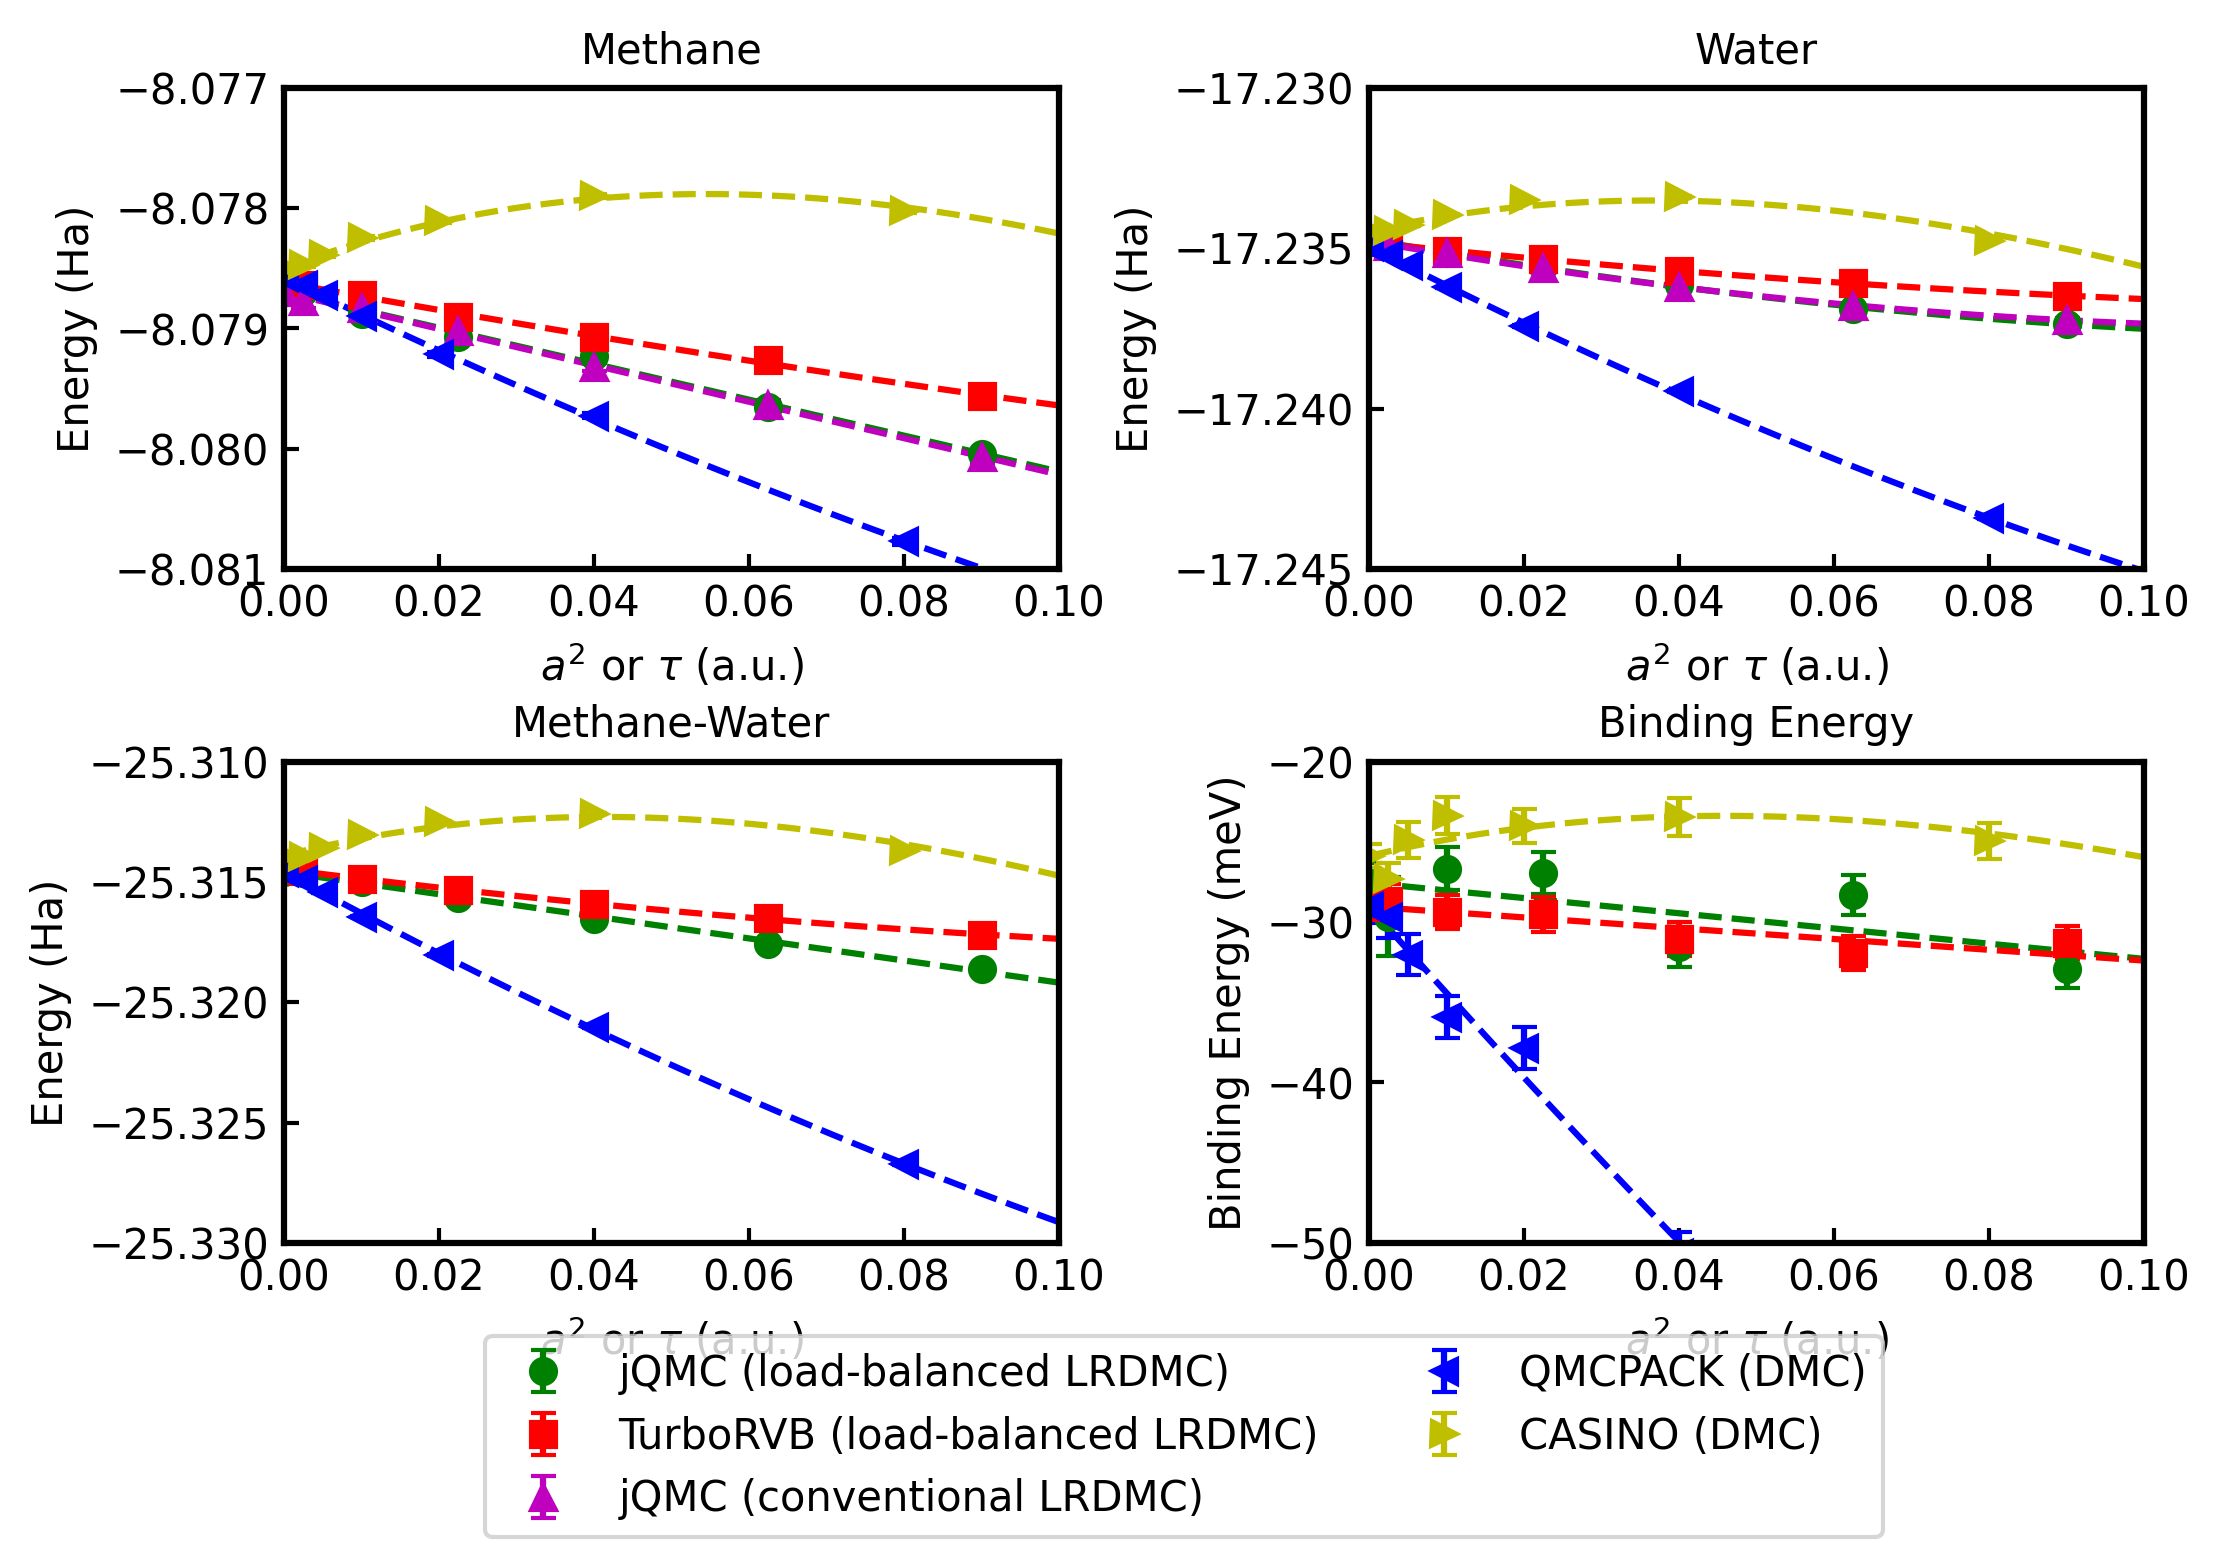

In [18]:
# plot Graph
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.width"] = 1.0
plt.rcParams["ytick.major.width"] = 1.0
plt.rcParams["font.size"] = 10
plt.rcParams["axes.linewidth"] = 1.5

# fig = plt.figure(figsize=(8, 5), facecolor="white", dpi=300, constrained_layout=True)

fig = plt.figure(figsize=(8, 5), facecolor="white", dpi=300)
fig.subplots_adjust(hspace=0.4)
fig.subplots_adjust(wspace=0.4)

plot_sigma = 1

# x min
x_min = 0.0
x_max = 0.1
xs = np.linspace(x_min, x_max, 100)

# methane
y_min = -8.081
y_max = -8.077
ax1 = fig.add_subplot(2, 2, 1)
ax1.set_title("Methane", fontsize=10)
ax1.set_xlabel(r"$a^2$ or $\tau$ (a.u.)")
ax1.set_ylabel("Energy (Ha)")
ax1.set_xlim([x_min, x_max])
ax1.set_ylim([y_min, y_max])
ax1.yaxis.set_major_formatter(formatter)

## jQMC
x = np.array(alat_list) ** 2
y = np.array([e.n for e in methane_lrdmc_energy])
yerr = np.array([e.s for e in methane_lrdmc_energy])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=1)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax1.errorbar(
    x, y, yerr=yerr * plot_sigma, color="g", marker="o", ls="", alpha=1.0, capsize=3, label="jQMC (load-balanced LRDMC)"
)
ax1.plot(xs, y_mean_plot, color="g", marker="", ls="--")
ax1.errorbar(0.0, E_ext.n, yerr=E_ext.s * plot_sigma, color="g", marker="o", alpha=1.0, capsize=3)
print(f"jQMC-methane: {E_ext:.1uS}")

## turborvb
alat_list_ref = list(methane_dmc_energy_ref["turborvb"].keys())
energy_list_ref = list(methane_dmc_energy_ref["turborvb"].values())
x = np.array([float(a) for a in alat_list_ref]) ** 2
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=2)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax1.errorbar(
    x, y, yerr=yerr * plot_sigma, color="r", marker="s", ls="", alpha=1.0, capsize=3, label="TurboRVB (load-balanced LRDMC)"
)
ax1.plot(xs, y_mean_plot, color="r", marker="", ls="--")
ax1.errorbar(0.0, E_ext.n, yerr=E_ext.s * plot_sigma, color="r", marker="s", alpha=1.0, capsize=3)
print(f"TurboRVB-methane: {E_ext:.1uS}")

"""
## jQMC (tau)
x = np.array(alat_list) ** 2
y = np.array([e.n for e in methane_lrdmc_tau_energy])
yerr = np.array([e.s for e in methane_lrdmc_tau_energy])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=1)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax1.errorbar(x, y, yerr=yerr*plot_sigma, color="m", marker="^", ls="", alpha=1.0, capsize=3, label="jQMC (conventional LRDMC)")
ax1.plot(xs, y_mean_plot, color="m", marker="", ls="--")
ax1.errorbar(0.0, E_ext.n, yerr=E_ext.s*plot_sigma, color="m", marker="^", alpha=1.0, capsize=3)
print(f'jQMC-methane(tau): {E_ext:.1uS}')
"""

"""
## turborvb-tau
alat_list_ref = list(methane_dmc_energy_ref["turborvb-tau"].keys())
energy_list_ref = list(methane_dmc_energy_ref["turborvb-tau"].values())
x = np.array([float(a) for a in alat_list_ref]) ** 2
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=2)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax1.errorbar(x, y, yerr=yerr*plot_sigma, color="r", marker="s", ls="", alpha=1.0, capsize=3, label="TurboRVB (conventional LRDMC)")
ax1.plot(xs, y_mean_plot, color="r", marker="", ls="--")
ax1.errorbar(0.0, E_ext.n, yerr=E_ext.s*plot_sigma, color="r", marker="s", alpha=1.0, capsize=3)
"""

## qmcpack
tau_list_ref = list(methane_dmc_energy_ref["qmcpack"].keys())
energy_list_ref = list(methane_dmc_energy_ref["qmcpack"].values())
x = np.array([float(t) for t in tau_list_ref])
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=2)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax1.errorbar(x, y, yerr=yerr * plot_sigma, color="b", marker="<", ls="", alpha=1.0, capsize=3, label="QMCPACK (DMC)")
ax1.plot(xs, y_mean_plot, color="b", marker="", ls="--")
ax1.errorbar(0.0, E_ext.n, yerr=E_ext.s * plot_sigma, color="b", marker="<", alpha=1.0, capsize=3)
ax1.yaxis.set_major_formatter(formatter)

## casino
tau_list_ref = list(methane_dmc_energy_ref["casino"].keys())
energy_list_ref = list(methane_dmc_energy_ref["casino"].values())
x = np.array([float(t) for t in tau_list_ref])
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=4)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax1.errorbar(x, y, yerr=yerr * plot_sigma, color="y", marker=">", ls="", alpha=1.0, capsize=3, label="CASINO (DMC)")
ax1.plot(xs, y_mean_plot, color="y", marker="", ls="--")
ax1.errorbar(0.0, E_ext.n, yerr=E_ext.s * plot_sigma, color="y", marker=">", alpha=1.0, capsize=3)
ax1.yaxis.set_major_formatter(formatter)

"""
## cmqmc
tau_list_ref = list(methane_dmc_energy_ref["cmqmc"].keys())
energy_list_ref = list(methane_dmc_energy_ref["cmqmc"].values())
x = np.array([float(t) for t in tau_list_ref])
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=4)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax1.errorbar(x, y, yerr=yerr*plot_sigma, color="c", marker="h", ls="", alpha=1.0, capsize=3, label="CMQMC (DMC)")
ax1.plot(xs, y_mean_plot, color="c", marker="", ls="--")
ax1.errorbar(0.0, E_ext.n, yerr=E_ext.s*plot_sigma, color="c", marker="s", alpha=1.0, capsize=3)
ax1.yaxis.set_major_formatter(formatter)
"""

# water
y_min = -17.245
y_max = -17.230
ax2 = fig.add_subplot(2, 2, 2)
ax2.set_title("Water", fontsize=10)
ax2.set_xlabel(r"$a^2$ or $\tau$ (a.u.)")
ax2.set_ylabel("Energy (Ha)")
ax2.set_xlim([x_min, x_max])
ax2.set_ylim([y_min, y_max])
ax2.yaxis.set_major_formatter(formatter)

## jQMC
x = np.array(alat_list) ** 2
y = np.array([e.n for e in water_lrdmc_energy])
yerr = np.array([e.s for e in water_lrdmc_energy])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=2)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax2.errorbar(
    x, y, yerr=yerr * plot_sigma, color="g", marker="o", ls="", alpha=1.0, capsize=3, label="jQMC (load-balanced LRDMC)"
)
ax2.plot(xs, y_mean_plot, color="g", marker="", ls="--")
ax2.errorbar(0.0, E_ext.n, yerr=E_ext.s * plot_sigma, color="g", marker="o", alpha=1.0, capsize=3)
print(f"jQMC-water: {E_ext:.1uS}")

## turborvb
alat_list_ref = list(water_dmc_energy_ref["turborvb"].keys())
energy_list_ref = list(water_dmc_energy_ref["turborvb"].values())
x = np.array([float(a) for a in alat_list_ref]) ** 2
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=2)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax2.errorbar(
    x, y, yerr=yerr * plot_sigma, color="r", marker="s", ls="", alpha=1.0, capsize=3, label="TurboRVB (load-balanced LRDMC)"
)
ax2.plot(xs, y_mean_plot, color="r", marker="", ls="--")
ax2.errorbar(0.0, E_ext.n, yerr=E_ext.s * plot_sigma, color="r", marker="s", alpha=1.0, capsize=3)
print(f"TurboRVB-water: {E_ext:.1uS}")

"""
## jQMC(tau)
x = np.array(alat_list) ** 2
y = np.array([e.n for e in water_lrdmc_tau_energy])
yerr = np.array([e.s for e in water_lrdmc_tau_energy])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=2)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax2.errorbar(x, y, yerr=yerr*plot_sigma, color="m", marker="^", ls="", alpha=1.0, capsize=3, label="jQMC (conventional LRDMC)")
ax2.plot(xs, y_mean_plot, color="m", marker="", ls="--")
ax2.errorbar(0.0, E_ext.n, yerr=E_ext.s*plot_sigma, color="m", marker="^", alpha=1.0, capsize=3)
print(f'jQMC-water(tau): {E_ext:.1uS}')
"""

"""
## turborvb-tau
alat_list_ref = list(water_dmc_energy_ref["turborvb-tau"].keys())
energy_list_ref = list(water_dmc_energy_ref["turborvb-tau"].values())
x = np.array([float(a) for a in alat_list_ref]) ** 2
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=2)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax2.errorbar(x, y, yerr=yerr*plot_sigma, color="r", marker="s", ls="", alpha=1.0, capsize=3, label="TurboRVB (conventional LRDMC)")
ax2.plot(xs, y_mean_plot, color="r", marker="", ls="--")
ax2.errorbar(0.0, E_ext.n, yerr=E_ext.s*plot_sigma, color="r", marker="s", alpha=1.0, capsize=3)
"""

## qmcpack
tau_list_ref = list(water_dmc_energy_ref["qmcpack"].keys())
energy_list_ref = list(water_dmc_energy_ref["qmcpack"].values())
x = np.array([float(t) for t in tau_list_ref])
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=2)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax2.errorbar(x, y, yerr=yerr * plot_sigma, color="b", marker="<", ls="", alpha=1.0, capsize=3, label="QMCPACK (DMC)")
ax2.plot(xs, y_mean_plot, color="b", marker="", ls="--")
ax2.errorbar(0.0, E_ext.n, yerr=E_ext.s * plot_sigma, color="b", marker="<", alpha=1.0, capsize=3)

## casino
tau_list_ref = list(water_dmc_energy_ref["casino"].keys())
energy_list_ref = list(water_dmc_energy_ref["casino"].values())
x = np.array([float(t) for t in tau_list_ref])
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=4)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax2.errorbar(x, y, yerr=yerr * plot_sigma, color="y", marker=">", ls="", alpha=1.0, capsize=3, label="CASINO (DMC)")
ax2.plot(xs, y_mean_plot, color="y", marker="", ls="--")
ax2.errorbar(0.0, E_ext.n, yerr=E_ext.s * plot_sigma, color="y", marker=">", alpha=1.0, capsize=3)

"""
## cmqmc
tau_list_ref = list(water_dmc_energy_ref["cmqmc"].keys())
energy_list_ref = list(water_dmc_energy_ref["cmqmc"].values())
x = np.array([float(t) for t in tau_list_ref])
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=4)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax2.errorbar(x, y, yerr=yerr*plot_sigma, color="c", marker=">", ls="", alpha=1.0, capsize=3, label="CMQMC (DMC)")
ax2.plot(xs, y_mean_plot, color="c", marker="", ls="--")
ax2.errorbar(0.0, E_ext.n, yerr=E_ext.s*plot_sigma, color="c", marker="h", alpha=1.0, capsize=3)
"""

# water--methane
y_min = -25.330
y_max = -25.310

ax3 = fig.add_subplot(2, 2, 3)
ax3.set_title("Methane-Water", fontsize=10)
ax3.set_xlabel(r"$a^2$ or $\tau$ (a.u.)")
ax3.set_ylabel("Energy (Ha)")
ax3.set_xlim([x_min, x_max])
ax3.set_ylim([y_min, y_max])
ax3.yaxis.set_major_formatter(formatter)

## jQMC
x = np.array(alat_list) ** 2
xs = np.linspace(x_min, x_max, 100)
y = np.array([e.n for e in water_methane_lrdmc_energy])
yerr = np.array([e.s for e in water_methane_lrdmc_energy])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=1)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax3.errorbar(
    x, y, yerr=yerr * plot_sigma, color="g", marker="o", ls="", alpha=1.0, capsize=3, label="jQMC (load-balanced LRDMC)"
)
ax3.plot(xs, y_mean_plot, color="g", marker="", ls="--")
ax3.errorbar(0.0, E_ext.n, yerr=E_ext.s * plot_sigma, color="g", marker="o", label="Extrapolated", alpha=1.0, capsize=3)
ax3.yaxis.set_major_formatter(formatter)
print(f"jQMC-methane-water: {E_ext:.1uS}")

## turborvb
alat_list_ref = list(water_methane_dmc_energy_ref["turborvb"].keys())
energy_list_ref = list(water_methane_dmc_energy_ref["turborvb"].values())
x = np.array([float(a) for a in alat_list_ref]) ** 2
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=2)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax3.errorbar(
    x, y, yerr=yerr * plot_sigma, color="r", marker="s", ls="", alpha=1.0, capsize=3, label="TurboRVB (load-balanced LRDMC)"
)
ax3.plot(xs, y_mean_plot, color="r", marker="", ls="--")
ax3.errorbar(0.0, E_ext.n, yerr=E_ext.s * plot_sigma, color="r", marker="s", alpha=1.0, capsize=3)
print(f"TurboRVB-methane-water: {E_ext:.1uS}")

## qmcpack
tau_list_ref = list(water_methane_dmc_energy_ref["qmcpack"].keys())
energy_list_ref = list(water_methane_dmc_energy_ref["qmcpack"].values())
x = np.array([float(t) for t in tau_list_ref])
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=2)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax3.errorbar(x, y, yerr=yerr * plot_sigma, color="b", marker="<", ls="", alpha=1.0, capsize=3, label="QMCPACK (DMC)")
ax3.plot(xs, y_mean_plot, color="b", marker="", ls="--")
ax3.errorbar(0.0, E_ext.n, yerr=E_ext.s * plot_sigma, color="b", marker="<", alpha=1.0, capsize=3)

## casino
tau_list_ref = list(water_methane_dmc_energy_ref["casino"].keys())
energy_list_ref = list(water_methane_dmc_energy_ref["casino"].values())
x = np.array([float(t) for t in tau_list_ref])
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=4)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax3.errorbar(x, y, yerr=yerr * plot_sigma, color="y", marker=">", ls="", alpha=1.0, capsize=3, label="CASINO (DMC)")
ax3.plot(xs, y_mean_plot, color="y", marker="", ls="--")
ax3.errorbar(0.0, E_ext.n, yerr=E_ext.s * plot_sigma, color="y", marker=">", alpha=1.0, capsize=3)

"""
## cmqmc
tau_list_ref = list(water_methane_dmc_energy_ref["cmqmc"].keys())
energy_list_ref = list(water_methane_dmc_energy_ref["cmqmc"].values())
x = np.array([float(t) for t in tau_list_ref])
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=4)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax3.errorbar(x, y, yerr=yerr*plot_sigma, color="c", marker="h", ls="", alpha=1.0, capsize=3, label="CMQMC (DMC)")
ax3.plot(xs, y_mean_plot, color="c", marker="", ls="--")
ax3.errorbar(0.0, E_ext.n, yerr=E_ext.s*plot_sigma, color="c", marker="s", alpha=1.0, capsize=3)
"""

# binding energy
y_min = -50.0
y_max = -20.0
ax4 = fig.add_subplot(2, 2, 4)
ax4.set_title("Binding Energy", fontsize=10)
ax4.set_xlabel(r"$a^2$ or $\tau$ (a.u.)")
ax4.set_ylabel("Binding Energy (meV)")
ax4.set_xlim([x_min, x_max])
ax4.set_ylim([y_min, y_max])
ax4.yaxis.set_major_formatter(formatter)

## jQMC
x = np.array(alat_list) ** 2
xs = np.linspace(x_min, x_max, 100)
y = np.array([e.n for e in binding_energy])
yerr = np.array([e.s for e in binding_energy])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=1)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax4.errorbar(
    x, y, yerr=yerr * plot_sigma, color="g", marker="o", ls="", alpha=1.0, capsize=3, label="jQMC (load-balanced LRDMC)"
)
ax4.plot(xs, y_mean_plot, color="g", marker="", ls="--")
ax4.errorbar(0.0, E_ext.n, yerr=E_ext.s * plot_sigma, color="g", marker="o", label="Extrapolated", alpha=1.0, capsize=3)
print(f"jQMC: Binding energy of Methane-Water dimer = {E_ext:.2uS} meV")

## turborvb
alat_list_ref = list(binding_energy_ref["turborvb"].keys())
energy_list_ref = list(binding_energy_ref["turborvb"].values())
x = np.array([float(a) for a in alat_list_ref]) ** 2
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=1)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax4.errorbar(
    x, y, yerr=yerr * plot_sigma, color="r", marker="s", ls="", alpha=1.0, capsize=3, label="TurboRVB (load-balanced LRDMC)"
)
ax4.plot(xs, y_mean_plot, color="r", marker="", ls="--")
ax4.errorbar(0.0, E_ext.n, yerr=E_ext.s * plot_sigma, color="r", marker="s", alpha=1.0, capsize=3)
print(f"TurboRVB: Binding energy of Methane-Water dimer = {E_ext:.1uS} meV")

## qmcpack
tau_list_ref = list(binding_energy_ref["qmcpack"].keys())
energy_list_ref = list(binding_energy_ref["qmcpack"].values())
x = np.array([float(t) for t in tau_list_ref])
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=2)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax4.errorbar(x, y, yerr=yerr * plot_sigma, color="b", marker="<", ls="", alpha=1.0, capsize=3, label="QMCPACK (DMC)")
ax4.plot(xs, y_mean_plot, color="b", marker="", ls="--")
ax4.errorbar(0.0, E_ext.n, yerr=E_ext.s * plot_sigma, color="b", marker="<", alpha=1.0, capsize=3)
print(f"QMCPACK: Binding energy of Methane-Water dimer = {E_ext:.2uS} meV")

## casino
tau_list_ref = list(binding_energy_ref["casino"].keys())
energy_list_ref = list(binding_energy_ref["casino"].values())
x = np.array([float(t) for t in tau_list_ref])
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=4)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax4.errorbar(x, y, yerr=yerr * plot_sigma, color="y", marker=">", ls="", alpha=1.0, capsize=3, label="CASINO (DMC)")
ax4.plot(xs, y_mean_plot, color="y", marker="", ls="--")
ax4.errorbar(0.0, E_ext.n, yerr=E_ext.s * plot_sigma, color="y", marker=">", alpha=1.0, capsize=3)
print(f"CASINO: Binding energy of Methane-Water dimer = {E_ext:.1uS} meV")

"""
## cmqmc
tau_list_ref = list(binding_energy_ref["cmqmc"].keys())
energy_list_ref = list(binding_energy_ref["cmqmc"].values())
x = np.array([float(t) for t in tau_list_ref])
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=2)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax4.errorbar(x, y, yerr=yerr*plot_sigma, color="c", marker="h", ls="", alpha=1.0, capsize=3, label="CMQMC (DMC)")
ax4.plot(xs, y_mean_plot, color="c", marker="", ls="--")
ax4.errorbar(0.0, E_ext.n, yerr=E_ext.s*plot_sigma, color="c", marker="s", alpha=1.0, capsize=3)
print(f"Binding energy of Methane-Water dimer = {E_ext:.1uS} meV")
"""

# Legend
h, l = ax2.get_legend_handles_labels()
handles = h
labels = l

fig.legend(handles, labels, loc="lower center", ncol=2, bbox_to_anchor=(0.5, -0.10), frameon=True)

plt.savefig("jqmc_validation_water_methane.jpg", bbox_inches="tight")
plt.show()

In [19]:
alat_list = alat_list
jQMC_lb = water_lrdmc_energy
jQMC_conv = water_lrdmc_tau_energy
turbo_lb = [water_dmc_energy_ref["turborvb"][alat] for alat in alat_list]
turbo_conv = [water_dmc_energy_ref["turborvb-tau"][alat] for alat in alat_list]

df = pd.DataFrame(
    {
        ("jQMC", "load-balanced"): jQMC_lb,
        ("jQMC", "conventional"): jQMC_conv,
        ("TurboRVB", "load-balanced"): turbo_lb,
        ("TurboRVB", "conventional"): turbo_conv,
    },
    index=alat_list,
)

df.index.name = "alat (Bohr)"
df.columns.names = ["Package", "Algorithm"]


def fmt_ufloat(x: ufloat) -> str:
    return f"{x:.1uS}$"


df_fmt = df.applymap(fmt_ufloat)

latex = df_fmt.to_latex(
    multicolumn=True,
    escape=False,
    column_format="c|cc|cc",
    caption="LRDMC energies of the water molecule for discretized lattice spacings ($a$), computed using both the load-balanced and conventional algorithms implemented in jQMC and TurboRVB.",
    label="tab:comparison_water_lrdmc_energies",
)

print(latex)

\begin{table}
\caption{LRDMC energies of the water molecule for discretized lattice spacings ($a$), computed using both the load-balanced and conventional algorithms implemented in jQMC and TurboRVB.}
\label{tab:comparison_water_lrdmc_energies}
\begin{tabular}{c|cc|cc}
\toprule
Package & \multicolumn{2}{r}{jQMC} & \multicolumn{2}{r}{TurboRVB} \\
Algorithm & load-balanced & conventional & load-balanced & conventional \\
alat (Bohr) &  &  &  &  \\
\midrule
0.050000 & -17.23483(3)$ & -17.23493(5)$ & -17.23485(2)$ & -17.23487(1)$ \\
0.100000 & -17.23516(2)$ & -17.23514(4)$ & -17.23509(2)$ & -17.23507(1)$ \\
0.150000 & -17.23559(3)$ & -17.23562(5)$ & -17.23535(2)$ & -17.23540(1)$ \\
0.200000 & -17.23616(2)$ & -17.23622(5)$ & -17.23571(2)$ & -17.23573(1)$ \\
0.250000 & -17.23688(2)$ & -17.23680(6)$ & -17.23608(2)$ & -17.23611(1)$ \\
0.300000 & -17.23735(2)$ & -17.23723(5)$ & -17.23648(2)$ & -17.23648(1)$ \\
\bottomrule
\end{tabular}
\end{table}



jQMC: Binding energy of Methane-Water dimer = -27.5(1.2) meV
TurboRVB: Binding energy of Methane-Water dimer = -29.0(7) meV
QMCPACK: Binding energy of Methane-Water dimer = -28.9(1.0) meV
CASINO: Binding energy of Methane-Water dimer = -25.9(7) meV


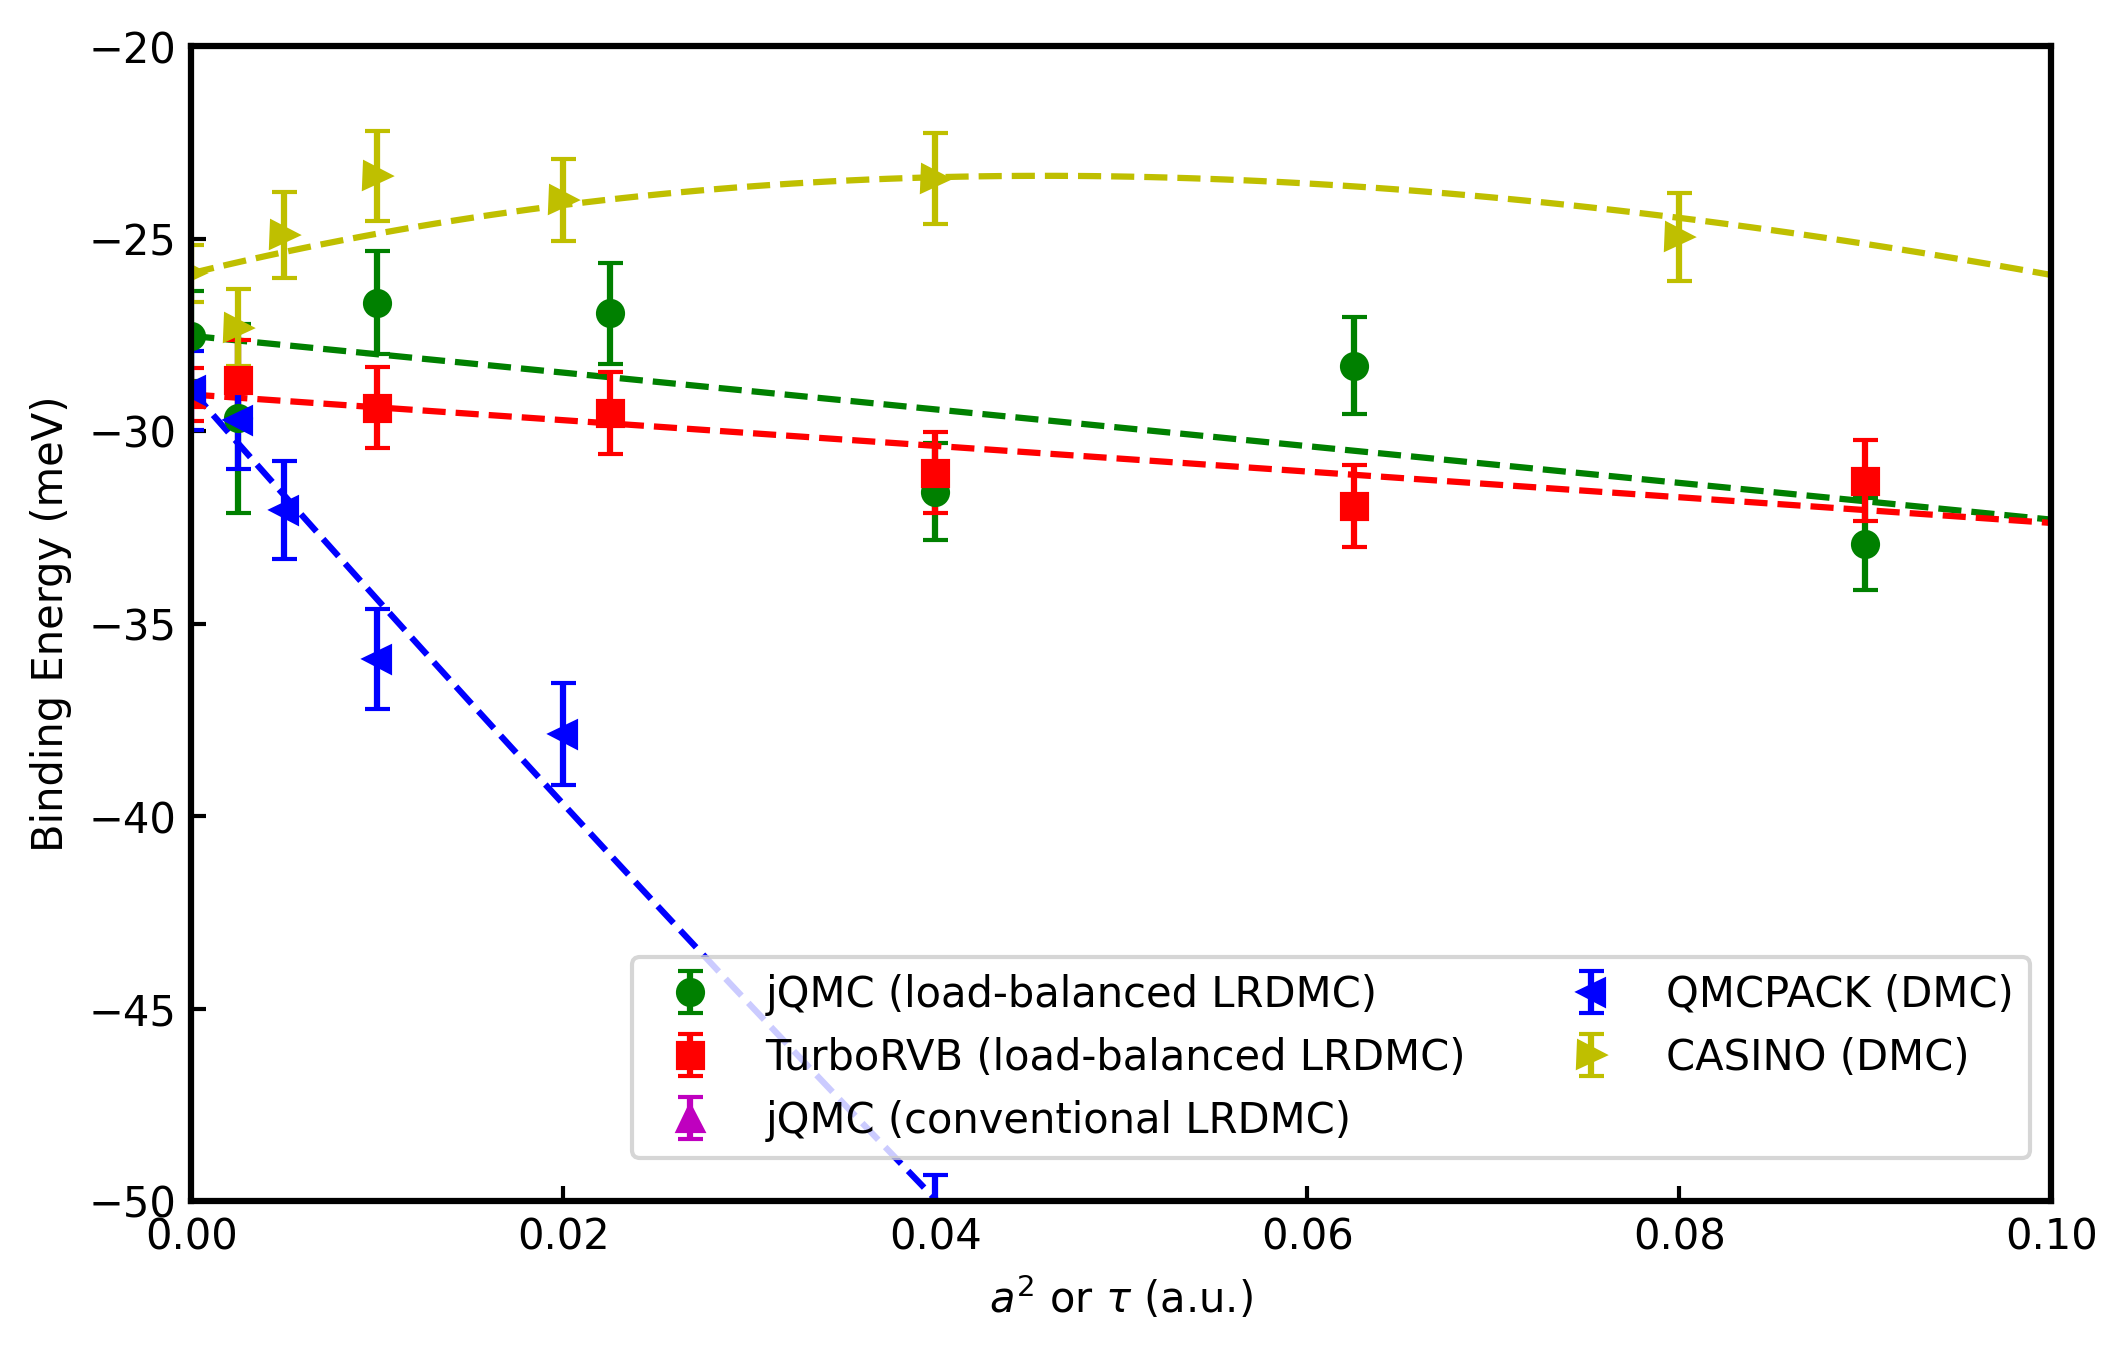

In [20]:
# plot Graph
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["xtick.direction"] = "in"
plt.rcParams["ytick.direction"] = "in"
plt.rcParams["xtick.major.width"] = 1.0
plt.rcParams["ytick.major.width"] = 1.0
plt.rcParams["font.size"] = 10
plt.rcParams["axes.linewidth"] = 1.5

fig = plt.figure(figsize=(8, 5), facecolor="white", dpi=300)
fig.subplots_adjust(hspace=0.4)
fig.subplots_adjust(wspace=0.4)

plot_sigma = 1

# x min
x_min = 0.0
x_max = 0.1
xs = np.linspace(x_min, x_max, 100)

# binding energy
y_min = -50.0
y_max = -20.0
ax4 = fig.add_subplot(1, 1, 1)
# ax4.set_title("Binding Energy", fontsize=10)
ax4.set_xlabel(r"$a^2$ or $\tau$ (a.u.)")
ax4.set_ylabel("Binding Energy (meV)")
ax4.set_xlim([x_min, x_max])
ax4.set_ylim([y_min, y_max])
ax4.yaxis.set_major_formatter(formatter)

## jQMC
x = np.array(alat_list) ** 2
xs = np.linspace(x_min, x_max, 100)
y = np.array([e.n for e in binding_energy])
yerr = np.array([e.s for e in binding_energy])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=1)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax4.errorbar(
    x, y, yerr=yerr * plot_sigma, color="g", marker="o", ls="", alpha=1.0, capsize=3, label="jQMC (load-balanced LRDMC)"
)
ax4.plot(xs, y_mean_plot, color="g", marker="", ls="--")
ax4.errorbar(0.0, E_ext.n, yerr=E_ext.s * plot_sigma, color="g", marker="o", label="Extrapolated", alpha=1.0, capsize=3)
print(f"jQMC: Binding energy of Methane-Water dimer = {E_ext:.2uS} meV")

## turborvb
alat_list_ref = list(binding_energy_ref["turborvb"].keys())
energy_list_ref = list(binding_energy_ref["turborvb"].values())
x = np.array([float(a) for a in alat_list_ref]) ** 2
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=1)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax4.errorbar(
    x, y, yerr=yerr * plot_sigma, color="r", marker="s", ls="", alpha=1.0, capsize=3, label="TurboRVB (load-balanced LRDMC)"
)
ax4.plot(xs, y_mean_plot, color="r", marker="", ls="--")
ax4.errorbar(0.0, E_ext.n, yerr=E_ext.s * plot_sigma, color="r", marker="s", alpha=1.0, capsize=3)
print(f"TurboRVB: Binding energy of Methane-Water dimer = {E_ext:.1uS} meV")

## qmcpack
tau_list_ref = list(binding_energy_ref["qmcpack"].keys())
energy_list_ref = list(binding_energy_ref["qmcpack"].values())
x = np.array([float(t) for t in tau_list_ref])
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=2)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax4.errorbar(x, y, yerr=yerr * plot_sigma, color="b", marker="<", ls="", alpha=1.0, capsize=3, label="QMCPACK (DMC)")
ax4.plot(xs, y_mean_plot, color="b", marker="", ls="--")
ax4.errorbar(0.0, E_ext.n, yerr=E_ext.s * plot_sigma, color="b", marker="<", alpha=1.0, capsize=3)
print(f"QMCPACK: Binding energy of Methane-Water dimer = {E_ext:.2uS} meV")

## casino
tau_list_ref = list(binding_energy_ref["casino"].keys())
energy_list_ref = list(binding_energy_ref["casino"].values())
x = np.array([float(t) for t in tau_list_ref])
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=4)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax4.errorbar(x, y, yerr=yerr * plot_sigma, color="y", marker=">", ls="", alpha=1.0, capsize=3, label="CASINO (DMC)")
ax4.plot(xs, y_mean_plot, color="y", marker="", ls="--")
ax4.errorbar(0.0, E_ext.n, yerr=E_ext.s * plot_sigma, color="y", marker=">", alpha=1.0, capsize=3)
print(f"CASINO: Binding energy of Methane-Water dimer = {E_ext:.1uS} meV")

"""
## cmqmc
tau_list_ref = list(binding_energy_ref["cmqmc"].keys())
energy_list_ref = list(binding_energy_ref["cmqmc"].values())
x = np.array([float(t) for t in tau_list_ref])
y = np.array([e.n for e in energy_list_ref])
yerr = np.array([e.s for e in energy_list_ref])
y_zero_list, y_mean, y_std, y_mean_plot, y_std_plot = fit_E_LRDMC(x, y, yerr, xs, order=2)
E_ext = ufloat(np.mean(y_zero_list), np.std(y_zero_list))
ax4.errorbar(x, y, yerr=yerr*plot_sigma, color="c", marker="h", ls="", alpha=1.0, capsize=3, label="CMQMC (DMC)")
ax4.plot(xs, y_mean_plot, color="c", marker="", ls="--")
ax4.errorbar(0.0, E_ext.n, yerr=E_ext.s*plot_sigma, color="c", marker="s", alpha=1.0, capsize=3)
print(f"Binding energy of Methane-Water dimer = {E_ext:.1uS} meV")
"""

# Legend
h, l = ax2.get_legend_handles_labels()
handles = h
labels = l

fig.legend(handles, labels, loc="lower center", ncol=2, bbox_to_anchor=(0.6, 0.125), frameon=True)

plt.savefig("jqmc_validation_water_methane_binding.jpg", bbox_inches="tight")
plt.show()